# Text generation

The goal of this project is to demonstrate text generation using LSTM neural networks.
Our database contains numerous movie plots taken from Wikipedia, so we will generate something similiar.

In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.models import Sequential
import random 
import matplotlib.pyplot as plt
import warnings
import os, multiprocessing

warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)


In [167]:
# Computer characteristics

mem_bytes = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')
mem_gib = mem_bytes / (1024.**3)
print("Computer characteristics: ")
print("RAM: %f GB" % mem_gib)
print("CORES: %d" % multiprocessing.cpu_count())


Computer characteristics: 
RAM: 12.715870 GB
CORES: 2


In [0]:
from google.colab import drive 

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [168]:
data = pd.read_csv("/content/drive/My Drive/Colab/movie_plots.csv")

movie_plots = data['Plot']

def count_words(text):
    return len(text.split())

print("Max movie plot len: ", movie_plots.map(count_words).max())
print("Min movie plot len: ", movie_plots.map(count_words).min())


# zadrzavamo samo opise sa vise od 300 reci
movie_plots = movie_plots[movie_plots.map(count_words) > 99]
print("Min movie plot len: ", movie_plots.map(count_words).min())
# i zadrzavamo sve koji imaju manje od 500 reci
movie_plots = movie_plots[movie_plots.map(count_words) < 301]
print("Max movie plot len: ", movie_plots.map(count_words).max())

all_plots = list(movie_plots.values)
# setting a seed so we get the same result every time
random.seed(64)
sample = random.sample(all_plots, 150)
sample[0]

Max movie plot len:  6752
Min movie plot len:  2
Min movie plot len:  100
Max movie plot len:  300


"Preeti Sengupta (Tanushree Dutta) is an air hostess living with her boyfriend Karan Malhotra (Rohit Roy). They share a nice 2BHK apartment in the northern suburbs of Mumbai and are befriended by their elderly neighbor Madhusudan Tanha (Anupam Kher), a struggling poet and lyricist. Tanha is a loner living with his only companion, a Persian cat whom he lovingly calls Shehzadi.\r\nPreeti is possessive and has issues with trust. When she mistakenly suspects her boyfriend to be unfaithful, she throws him out of the house, but soon realizes she can't afford the apartment rent on her own. On the advice of a fellow airhostess, she advertises for a tenant to share her apartment. Enter Neha Bhardwaj (Neetu Chandra), a modest small-town girl asking for accommodation. Very impressed by her simplicity and respectfulness, Preeti believes she has found a perfect roommate. The two girls soon become close - their camaraderie leads them to become companions.\r\nThen things begin to go disastrously wron

## Tokenize words

Tokenization is turning unique words into unique integers. This step is necessary for preparing data for embedding layer.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [169]:
from keras.preprocessing.text import Tokenizer

max_words = 5000
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(sample)

reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))


sequences = tokenizer.texts_to_sequences(sample)
sequences_len = 200
sequences = pad_sequences(sequences, maxlen = sequences_len, truncating = 'post')


sequences.shape
print(sequences[0])

[ 850 2770 2771 1663    6   23 1664 2772  354   10   11  564 2773 2774
  185 1148   26  700    4 2775 2776  462    7    1 1149 2777    5 1665
    3   28 1666   13   25 1150 1667 2778 1668 1669 1670    4  463 2779
    3 2780 1668    6    4 2781  354   10    8   71 1671    4 2782  464
  174    9 2783  465 2784   17  850    6 1672    3   27 2785   10  701
   22   16 1673  702   11  564    2   36 2786   16  703   20   33    5
    1  109   21  135  403   16  851 1674    1  462 1675   19   11   79
   19    1 1151    5    4 1676 2787   16 2788   12    4 1152    2  700
   11  462  565 1153 2789 2790 2791    4 2792  355  151   87 1154   12
 2793  162 1155   13   11 2794    3 2795  850  276   16   27  219    4
 1677 1678    1   53  202  135  104  466   25 2796  203   38    2  104
 2797   17   42  246  247    2   98 2798  220 2799    3 1679 2800 2801
  566   50    6 1680   99 1681   10    4  248    5 2802   15   75   11
   13 1156    6   29   88 2803  175    6  852 2804 1157   46    1  853
    6 

In [170]:
# making a single list of tokens so we can apply sliding windows

text = [item for sublist in sequences for item in sublist]
print("Corpus size: ", len(text))
vocab_size = len(tokenizer.word_index)
print("Vocabulary size: ", vocab_size+1)


Corpus size:  30000
Vocabulary size:  6484


In [0]:
# reverse dictionary so we can decode tokenized sequences back to words

reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))


### Splitting the data for input and output values

Input sequence has the size of 4 words, and output is the next word

In [172]:
seq_len = 4

dataX = []
dataY = []

for i in range(len(text)-seq_len):
    seq_in = text[i:i+seq_len]
    seq_out = text[i+seq_len]
    dataX.append(seq_in)
    dataY.append(seq_out)
    
    
lenX = len(dataX)
print(lenX)

29996


In [0]:
from keras.utils import np_utils

dataX = np.asarray(dataX)
dataY = np_utils.to_categorical(dataY)

### Split into train and test set

In [174]:
from sklearn.model_selection import train_test_split


trainX, testX, trainy, testy = train_test_split(dataX, dataY, test_size = 0.2)
print(trainX.shape)
print(testX.shape)
print(trainy.shape)
print(testy.shape)

(23996, 4)
(6000, 4)
(23996, 5000)
(6000, 5000)


### Creating a model

In [175]:
import keras
from keras.layers import LSTM, Dense, Embedding, Dropout
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(Embedding(vocab_size+1, 32, input_length = trainX.shape[1]))
model.add(LSTM(50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(200, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(250))
model.add(Dropout(0.2))
model.add(Dense(trainy.shape[1], activation = 'softmax'))

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 4, 32)             207488    
_________________________________________________________________
lstm_34 (LSTM)               (None, 4, 50)             16600     
_________________________________________________________________
dropout_27 (Dropout)         (None, 4, 50)             0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 4, 200)            200800    
_________________________________________________________________
dropout_28 (Dropout)         (None, 4, 200)            0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 250)               451000    
_________________________________________________________________
dropout_29 (Dropout)         (None, 250)             

In [176]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

filepath = "./20e100n.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor = 'loss', 
                             verbose = 1, save_best_only = True, mode = 'min')
callbacks = [checkpoint]

hist = model.fit(trainX, trainy, epochs = 20, batch_size = 128, 
                 verbose = 1, callbacks = callbacks, validation_split = 0.1)


Train on 21596 samples, validate on 2400 samples
Epoch 1/20
21596/21596 [==============================] - 6s 274us/step - loss: 6.3259 - acc: 0.1756 - val_loss: 5.8479 - val_acc: 0.2075

Epoch 00001: loss improved from inf to 6.32593, saving model to ./20e100n.hdf5
Epoch 2/20
21596/21596 [==============================] - 5s 229us/step - loss: 5.6296 - acc: 0.2079 - val_loss: 5.8924 - val_acc: 0.2125

Epoch 00002: loss improved from 6.32593 to 5.62961, saving model to ./20e100n.hdf5
Epoch 3/20
21596/21596 [==============================] - 5s 229us/step - loss: 5.5404 - acc: 0.2104 - val_loss: 5.9311 - val_acc: 0.2129

Epoch 00003: loss improved from 5.62961 to 5.54039, saving model to ./20e100n.hdf5
Epoch 4/20
21596/21596 [==============================] - 5s 229us/step - loss: 5.4944 - acc: 0.2106 - val_loss: 5.9919 - val_acc: 0.2129

Epoch 00004: loss improved from 5.54039 to 5.49439, saving model to ./20e100n.hdf5
Epoch 5/20
21596/21596 [==============================] - 5s 226us/

In [0]:
filename = "20e100n.hdf5"
model.load_weights(filename)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])


In [178]:
# Evaluate model on test set (accuracy and error)

results = model.evaluate(testX, testy, batch_size = 128)
print('Loss: %.2f'% results[0])
print('Accuracy: %.2f'%(results[1]*100), "%")

6000/6000 [==============================] - 0s 69us/step
Loss: 7.18
Accuracy: 21.28 %


###Model accuracy

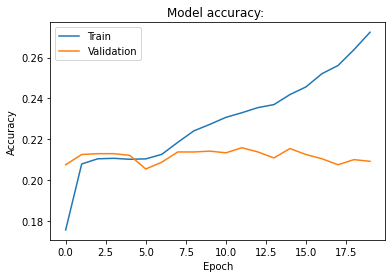

In [179]:
plt.plot(hist.history["acc"])
plt.plot(hist.history["val_acc"])
plt.title('Model accuracy: ')
plt.legend(['Train', 'Validation'], loc='best')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

### Model loss

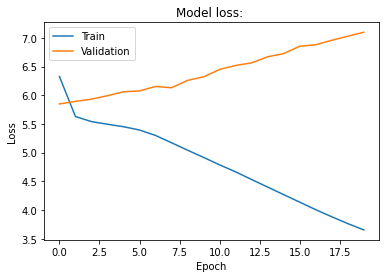

In [180]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title('Model loss: ')
plt.legend(['Train', 'Validation'], loc='best')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [0]:
def generate_words(seed_text, num_words, model, max_seq_len = 4):
    for i in range(num_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen = max_seq_len, padding = 'pre')
        
        predicted = model.predict_classes(token_list, verbose = 0)
        output_word = ''
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
                
        seed_text = seed_text + " " + output_word
        
    return seed_text.title()

In [182]:
print(generate_words("The movie is about", 20, model))

The Movie Is About A New Woman And Howard Denmark A Goldberg Disaster Ignorance And Or 4 Guilt In The Film Of The Successful
